## Experiments

In [72]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
import os
from collections import defaultdict
from tqdm.auto import tqdm, trange

import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

### Some boilerplate code

In [73]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = defaultdict(int)
        self.avg = defaultdict(int)
        self.sum = defaultdict(int)
        self.count = defaultdict(int)

    def update(self, n=1, **val):
        for k in val:
            self.val[k] = val[k]
            self.sum[k] += val[k] * n
            self.count[k] += n
            self.avg[k] = self.sum[k] / self.count[k]


class Logger(object):
    """Stores train and test error during training"""
    def __init__(self):
        self.train_error = []
        self.test_error = []
    
    def update_train_error(self, error):
        self.train_error.append(error)
    
    def update_test_error(self, error):
        self.test_error.append(error)
    
    def plot(self):
        plt.plot(range(len(self.train_error)), self.train_error, label='train error')
        plt.plot(range(len(self.test_error)), self.test_error, label='test_error')
        plt.xlabel("Epoch")
        plt.ylabel("Error (%)")
        plt.ylim(bottom=0)
        plt.legend()


class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

### Data loaders

Create loaders for the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). Note that we use data augmentation for the training set, and we renormalize the images using the empirical mean and variance.

In [74]:
def get_cifar10_dataloaders():
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4, padding_mode='edge'),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.49, 0.48, 0.45), std=(0.20, 0.19, 0.20)),
        ])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.49, 0.48, 0.45), std=(0.20, 0.19, 0.20)),
        ])
    train_set = datasets.CIFAR10(root=os.path.expanduser('~/data'), train=True, transform=train_transform, download=True)
    test_set = datasets.CIFAR10(root=os.path.expanduser('~/data'), train=False, transform=test_transform)

    train_loader = DataLoader(train_set, shuffle=True, batch_size=128, num_workers=4)
    test_loader = DataLoader(test_set, shuffle=False, batch_size=100, num_workers=4)
    return train_loader, test_loader

train_loader, test_loader = get_cifar10_dataloaders()

Files already downloaded and verified


### Displays the some images from the train and test set

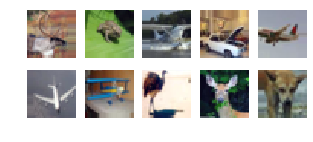

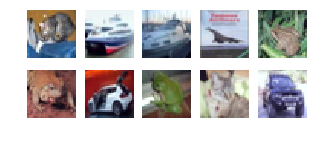

In [75]:
def display_batch(batch):
    fig, axes = plt.subplots(2, 5, figsize=(5, 2))
    for i, ax in enumerate(axes.reshape(-1)):
        ax.imshow(np.clip((batch[0][i] * 0.2 + 0.5).permute(1,2,0), 0, 1))
        ax.set_axis_off()
    fig.show()
display_batch(next(iter(train_loader)))
display_batch(next(iter(test_loader)))

### Code for training a model

In [76]:
def run_epoch(data_loader, model, optimizer, train=True, logger=None, epoch=0):
    meter = AverageMeter()
    for input, target in tqdm(data_loader, leave=False):
        input, target = input.to(device), target.to(device)

        prediction = model(input)
        loss = loss_fn(prediction, target)
        
        error = (prediction.argmax(dim=1) != target).float().mean().item() * 100
        meter.update(n=input.size(0), loss=loss.item(), error=error)

        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    if train:
        logger.update_train_error(meter.avg['error'])
    else:
        logger.update_test_error(meter.avg['error'])

def train(model, loss_fn, train_loader, test_loader, logger, epochs=160):
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.97)
    try:
        with trange(epochs, leave=False) as t:
            for epoch in t:
                run_epoch(train_loader, model, optimizer, train=True, logger=logger, epoch=epoch)
                run_epoch(test_loader, model, optimizer=None, train=False, logger=logger, epoch=epoch)
                lr_scheduler.step()
                t.set_postfix(epoch=epoch, train=f'{logger.train_error[-1]:.2f}%', test=f'{logger.test_error[-1]:.2f}%')
    except KeyboardInterrupt:
        print("Training interrupted")
    print(f"Final train error: {logger.train_error[-1]:.2f}%   test error: {logger.test_error[-1]:.2f}%")


logs = defaultdict(Logger)
loss_fn = nn.CrossEntropyLoss().to(device)

### Fully connected model

A fully connected neural network, with two hidden layers of size 128.

In [77]:
class FullyConnectedModel(nn.Module):
    def __init__(self, n_channels=3, n_filters1=128, n_filters2=128, n_classes=10):
        super().__init__()
        self.classifier = nn.Sequential(
            Flatten(),
            nn.Linear(32 * 32 * n_channels, n_filters1),
            nn.ReLU(),
            nn.Linear(n_filters1, n_filters2),
            nn.ReLU(),
            nn.Linear(n_filters2, n_classes)
        )
    
    def forward(self, x):
        return self.classifier(x)
model = FullyConnectedModel()
train(model, loss_fn, train_loader, test_loader, logger=logs[model.__class__.__name__])

Final train error: 38.71%   test error: 38.18%


### Linear model

A linear classifier, with a softmax activation function (the softmax is hidden in the loss function: [`nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html?highlight=crossentropyloss#torch.nn.CrossEntropyLoss) applies a softmax).

In [78]:
class LinearModel(nn.Module):
    def __init__(self, n_channels=3, n_classes=10):
        super().__init__()
        self.classifier = nn.Sequential(
            Flatten(),
            nn.Linear(32 * 32 * n_channels, n_classes)
        )
    
    def forward(self, x):
        return self.classifier(x)
model = LinearModel()
train(model, loss_fn, train_loader, test_loader, logger=logs[model.__class__.__name__])

Final train error: 65.25%   test error: 61.90%


### Shallow convolutional model

A convolutional neural network with one hidden (convolutional) layer.
This network learns 64 convolution kernels of size 5x5.

In [79]:
class ShallowConvModel(nn.Module):
    def __init__(self, n_channels=3, n_filters1=32, n_filters2=64, n_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(n_channels, n_filters2, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
        )
        self.classifier = nn.Sequential(
            Flatten(),
            nn.Linear(n_filters2, n_classes)
        )
    
    def forward(self, x):
        z = self.features(x)
        return self.classifier(z)
model = ShallowConvModel()
train(model, loss_fn, train_loader, test_loader, logger=logs[model.__class__.__name__])

Final train error: 45.77%   test error: 44.70%


### Deep convolutional model (first version)

A deep convolutional neural network, with 7 (convolutional) hidden layers. The convolution kernels have size 3x3 (in the first 5 hidden layers) and 1x1 (in the last 2 hidden layers)

In [80]:
class SimpleAllCNN(nn.Module):
    """
    AllCNN with no max-pooling, no stride=2, no batch normalization.
    """
    name = "Convolutional model (no max pool)"
    def __init__(self, n_channels=3, n_classes=10):
        super().__init__()
        n_filters1 = 96
        n_filters2 = 192
        self.features = nn.Sequential(
            nn.Conv2d(n_channels, n_filters1, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(n_filters1, n_filters1, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(n_filters1, n_filters1, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(n_filters1, n_filters1, kernel_size=3),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Conv2d(n_filters1, n_filters1, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(n_filters1, n_filters1, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(n_filters1, n_classes, kernel_size=1),
            nn.AdaptiveAvgPool2d((1, 1))
        )
    
    def forward(self, x):
        features = self.features(x)
        return self.classifier(features).squeeze()
model = SimpleAllCNN()
train(model, loss_fn, train_loader, test_loader, logger=logs[model.__class__.__name__])

Final train error: 4.42%   test error: 13.64%


### Deep convolutional model (second version)

A deep convolutional neural network as in the first version, but with two max-pool operations (after the 2nd and the 4th convolutional layer).
Max-pooling downsamples the feature maps by a factor of 2 in both spatial dimensions.

In [81]:
class AllCNN(nn.Module):
    """
    AllCNN with max-pooling, no batch normalization.
    """
    name = "Convolutional model"
    def __init__(self, n_channels=3, n_classes=10):
        super().__init__()
        n_filters1 = 96
        n_filters2 = 192
        self.features = nn.Sequential(
            nn.Conv2d(n_channels, n_filters1, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(n_filters1, n_filters2, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(n_filters2, n_filters2, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(n_filters2, n_filters2, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Conv2d(n_filters2, n_filters2, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(n_filters2, n_filters2, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(n_filters2, n_classes, kernel_size=1),
            nn.AdaptiveAvgPool2d((1, 1))
        )
    
    def forward(self, x):
        features = self.features(x)
        return self.classifier(features).squeeze()
model = AllCNN()
train(model, loss_fn, train_loader, test_loader, logger=logs[model.__class__.__name__])

Final train error: 0.81%   test error: 10.02%


### Deep convolutional model (third version)

As in the first two versions, but we add batch normalization in every hidden layer.

In [82]:
class BNAllCNN(nn.Module):
    """
    AllCNN with max-pooling and batch normalization.
    """
    name = "Convolutional model + BN"
    def __init__(self, n_channels=3, n_classes=10):
        super().__init__()
        n_filters1 = 96
        n_filters2 = 192
        self.features = nn.Sequential(
            nn.Conv2d(n_channels, n_filters1, kernel_size=3),
            nn.BatchNorm2d(n_filters1),
            nn.ReLU(),
            nn.Conv2d(n_filters1, n_filters2, kernel_size=3),
            nn.BatchNorm2d(n_filters2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(n_filters2, n_filters2, kernel_size=3),
            nn.BatchNorm2d(n_filters2),
            nn.ReLU(),
            nn.Conv2d(n_filters2, n_filters2, kernel_size=3),
            nn.BatchNorm2d(n_filters2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Conv2d(n_filters2, n_filters2, kernel_size=3),
            nn.BatchNorm2d(n_filters2),
            nn.ReLU(),
            nn.Conv2d(n_filters2, n_filters2, kernel_size=1),
            nn.BatchNorm2d(n_filters2),
            nn.ReLU(),
            nn.Conv2d(n_filters2, n_classes, kernel_size=1),
            nn.AdaptiveAvgPool2d((1, 1))
        )
    
    def forward(self, x):
        features = self.features(x)
        return self.classifier(features).squeeze()
model = BNAllCNN()
train(model, loss_fn, train_loader, test_loader, logger=logs[model.__class__.__name__])

Final train error: 0.11%   test error: 8.91%


### Plot of the results for all models

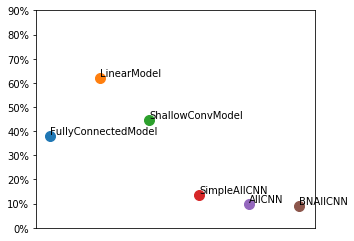

In [83]:
results = {}
fig, ax = plt.subplots(1,1, figsize=(5, 4))
for i, (k, logger) in enumerate(logs.items()):
    results[k] = logger.test_error[-1]
    ax.scatter(i, logger.test_error[-1], s=100)
    ax.annotate(k, (i, logger.test_error[-1] + .7))
ax.set_ylim(0, 90)
vals = ax.get_yticks()
ax.set_yticklabels(['{:.0f}%'.format(x) for x in vals])
ax.get_xaxis().set_visible(False)

### Plot filters

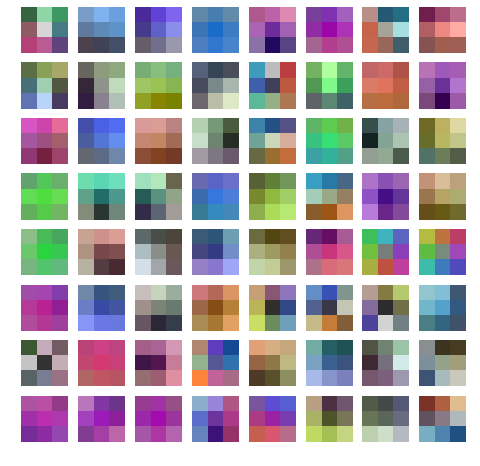

In [84]:
def normalize_filters(w):
    w = w - w.mean()
    w /= w.std()
    return np.clip(.2 * w + .5, 0, 1)
filters = normalize_filters(model.features[0].weight.data.cpu().numpy().transpose(0, 2, 3, 1))

fig, axes = plt.subplots(8, 8, figsize=(8,8), sharex=True, sharey=True)
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(normalize_filters(filters[i]), vmin=-1, vmax=1)
    ax.set_axis_off()